<a href="https://colab.research.google.com/github/Sievv/AMPs-against-KP/blob/main/Modification_AMPs_against_KP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AMP criteria and mutation logic using the model's predictions ,

Model's Role:
The trained models (Random Forest, Gradient Boosting, AdaBoost) predict the likelihood of a peptide being antimicrobial based on these features.

| **Feature**                | **Criteria for AMP**             |  
| -------------------------- | -------------------------------- |
| **Peptide Length**         | ≤ 20 amino acids                 |
| **Charge**                 | Between 2 and 9                  |
| **Hydrophobicity**         | 30% to 50% hydrophobic residues  |
| **Isoelectric Point (pI)** | > 9                              |
| **Helix Content**          | ≥ 5 residues in alpha-helix form |
| **Proline Count**          | ≤ 1 proline                      |


| **Mutation Goal**            | **Action**                                                                                                   |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Increase Positive Charge** | Replace neutral/polar residues with `K` or `R`                                                               |
| **Preserve Helix**           | Replace proline (`P`) with alanine (`A`)                                                                     |
| **Maintain Hydrophobicity**  | Replace some hydrophobic residues (`I`, `L`, `F`) with `K` or `R`, but keep hydrophobicity ≥ 70% of original |


In [4]:
from google.colab import drive

# Optional: Unmount if it was previously mounted but failed
try:
  drive.flush_and_unmount()
except ValueError:
  pass # Ignore if not mounted

# Attempt to mount Google Drive again
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


prediction

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq
import random

# Load trained models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random_Forest_fixed_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient_Boosting_fixed_model.pkl')
ada_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_fixed_model.pkl')

# Load dataset of inactive peptides
inactive_df = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/Inactive 373.csv', encoding='ISO-8859-1')
seq_col_name = 'Sequence'

if seq_col_name not in inactive_df.columns:
    raise ValueError(f"Sequence column '{seq_col_name}' not found in inactive data.")

# --- Feature calculation functions ---
def calculate_charge(sequence):
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_hydrophobicity(sequence):
    hydrophobic_residues = 'AVILMFYW'
    return sum(sequence.count(aa) for aa in hydrophobic_residues)

def calculate_molecular_weight(sequence):
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_number_of_cysteines(sequence):
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    return calculate_number_of_cysteines(sequence) // 2

def calculate_isoelectric_point(sequence):
    pKa_acidic = {'D':3.9, 'E':4.25}
    pKa_basic = {'K':10.5, 'R':12.5, 'H':6.0}
    acidic_count = sum(sequence.count(aa) for aa in pKa_acidic)
    basic_count = sum(sequence.count(aa) for aa in pKa_basic)
    if acidic_count + basic_count == 0:
        return 7.0
    total_charge_pI = sum(pKa_acidic[aa]*sequence.count(aa) for aa in pKa_acidic) + sum(pKa_basic[aa]*sequence.count(aa) for aa in pKa_basic)
    return total_charge_pI / (acidic_count + basic_count)

def amino_acid_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {aa: (sequence.count(aa) / total * 100 if total > 0 else 0) for aa in amino_acids}

def secondary_structure_features(sequence):
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum(sequence.count(aa) for aa in helix_aa)
    sheet = sum(sequence.count(aa) for aa in sheet_aa)
    turn = sum(sequence.count(aa) for aa in turn_aa)
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load feature columns from training set or fallback list
try:
    X_train_cols = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/X_train.csv').columns.tolist()
except FileNotFoundError:
    print("Warning: X_train.csv not found, using predefined feature list.")
    X_train_cols = ['Length', 'Charge', 'Hydrophobicity', 'Molecular_Weight',
                    'Number_of_Cysteines', 'Number_of_Disulfide_Bridges', 'Isoelectric_Point',
                    'Helix', 'Turn', 'Sheet', 'Flexibility'] + list('ACDEFGHIKLMNPQRSTVWY')
feature_columns_for_prediction = X_train_cols

# --- Antimicrobial peptide (AMP) criteria function ---
def amp_criteria(features):
    length_ok = features['Length'] <= 20
    charge = features['Charge']
    charge_ok = 2 <= charge <= 9
    hydro_percent = (features['Hydrophobicity'] / features['Length']) * 100 if features['Length'] > 0 else 0
    hydro_ok = 30 <= hydro_percent <= 50
    pi_ok = features['Isoelectric_Point'] > 9
    helix_ok = features['Helix'] >= 5  # Example threshold, adjust if needed
    proline_count = features.get('P', 0)
    proline_ok = proline_count <= 1

    return all([length_ok, charge_ok, hydro_ok, pi_ok, helix_ok, proline_ok])

# --- Mutation function based on design principles and LIME explanation ---
def mutate_sequence(seq):
    seq_list = list(seq)
    neutral_polar = ['G','S','T','N','Q']
    positive_residues = ['K','R']
    hydrophobic_residues = ['I','L','F']
    helix_breakers = ['P']

    initial_hydro = calculate_hydrophobicity(seq)

    for i, aa in enumerate(seq_list):
        # Increase net positive charge by replacing neutral/polar residues with K or R
        if aa in neutral_polar:
            seq_list[i] = random.choice(positive_residues)
            continue
        # Maintain helix by replacing helix breakers like P with alanine (A)
        if aa in helix_breakers:
            seq_list[i] = 'A'
            continue
        # Balance hydrophobicity: selectively replace some hydrophobic residues with K or R without dropping below 70% hydrophobicity
        if aa in hydrophobic_residues and random.random() < 0.3:
            temp_seq = seq_list.copy()
            temp_seq[i] = random.choice(positive_residues)
            new_hydro = calculate_hydrophobicity(''.join(temp_seq))
            if new_hydro >= initial_hydro * 0.7:
                seq_list[i] = temp_seq[i]
    return ''.join(seq_list)

# Helper to compute all features for a sequence in the right order
def calc_features_dict(seq):
    features = {
        'Length': len(seq),
        'Charge': calculate_charge(seq),
        'Hydrophobicity': calculate_hydrophobicity(seq),
        'Molecular_Weight': calculate_molecular_weight(seq),
        'Number_of_Cysteines': calculate_number_of_cysteines(seq),
        'Number_of_Disulfide_Bridges': calculate_number_of_disulfide_bridges(seq),
        'Isoelectric_Point': calculate_isoelectric_point(seq),
    }
    features.update(amino_acid_composition(seq))
    helix, turn, sheet, flexibility = secondary_structure_features(seq)
    features.update({'Helix': helix, 'Turn': turn, 'Sheet': sheet, 'Flexibility': flexibility})
    return features

# --- Main mutation and prediction loop ---
max_iterations = 30
comparison_results = []

for idx, row in inactive_df.iterrows():
    original_seq = row[seq_col_name]
    mutated_seq = original_seq

    # Compute original features and model probabilities
    orig_features = calc_features_dict(original_seq)
    orig_vector = [orig_features.get(col, 0) for col in feature_columns_for_prediction]
    orig_rf_prob = rf_model.predict_proba(np.array(orig_vector).reshape(1, -1))[:,1][0]
    orig_gb_prob = gb_model.predict_proba(np.array(orig_vector).reshape(1, -1))[:,1][0]
    orig_ada_prob = ada_model.predict_proba(np.array(orig_vector).reshape(1, -1))[:,1][0]

    for iteration in range(max_iterations):
        mutated_seq = mutate_sequence(mutated_seq)
        mut_features = calc_features_dict(mutated_seq)
        mut_vector = [mut_features.get(col, 0) for col in feature_columns_for_prediction]

        mut_rf_prob = rf_model.predict_proba(np.array(mut_vector).reshape(1, -1))[:,1][0]
        mut_gb_prob = gb_model.predict_proba(np.array(mut_vector).reshape(1, -1))[:,1][0]
        mut_ada_prob = ada_model.predict_proba(np.array(mut_vector).reshape(1, -1))[:,1][0]

        # Accept mutated peptide if it meets AMP criteria and is predicted active by RF model (prob >= 0.5)
        if mut_rf_prob >= 0.5 and amp_criteria(mut_features):
            comparison_results.append({
                'Original_Sequence': original_seq,
                'Mutated_Sequence': mutated_seq,
                'RF_Orig_Prob': orig_rf_prob,
                'RF_Mut_Prob': mut_rf_prob,
                'GB_Orig_Prob': orig_gb_prob,
                'GB_Mut_Prob': mut_gb_prob,
                'Ada_Orig_Prob': orig_ada_prob,
                'Ada_Mut_Prob': mut_ada_prob,
                'Iteration_Converted': iteration + 1,
                **{f'Orig_{k}': v for k,v in orig_features.items()},
                **{f'Mut_{k}': v for k,v in mut_features.items()}
            })
            print(f"Peptide {idx} converted at iteration {iteration+1} with RF prob {mut_rf_prob:.3f}")
            break

# Save the comparison data for all converted peptides
comparison_df = pd.DataFrame(comparison_results)
if not comparison_df.empty:
    output_path = '/content/drive/MyDrive/KP/converted_peptides_feature_comparisonv1.csv'
    comparison_df.to_csv(output_path, index=False)
    print(f"\nSaved comparison data for {len(comparison_df)} peptides to:\n{output_path}")
else:
    print("\nNo peptides converted within given iterations and criteria.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 8 converted at iteration 1 with RF prob 0.694


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted

Peptide 49 converted at iteration 1 with RF prob 0.626


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 52 converted at iteration 1 with RF prob 0.675


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 54 converted at iteration 1 with RF prob 0.724


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted

Peptide 122 converted at iteration 1 with RF prob 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 125 converted at iteration 1 with RF prob 0.639


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 131 converted at iteration 4 with RF prob 0.787


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 147 converted at iteration 1 with RF prob 0.585


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 156 converted at iteration 1 with RF prob 0.589


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 175 converted at iteration 1 with RF prob 0.656


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted

Peptide 218 converted at iteration 1 with RF prob 0.583


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 237 converted at iteration 1 with RF prob 0.723
Peptide 238 converted at iteration 1 with RF prob 0.580


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 252 converted at iteration 4 with RF prob 0.568


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 254 converted at iteration 1 with RF prob 0.579


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted

Peptide 302 converted at iteration 1 with RF prob 0.728


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted


Saved comparison data for 16 peptides to:
/content/drive/MyDrive/KP/converted_peptides_feature_comparisonv1.csv


In [ ]:
print(comparison_df)

       Original_Sequence      Mutated_Sequence  RF_Orig_Prob  RF_Mut_Prob  \
0    KGVPTSTVYAQILFEENQL   KKVARRRVYAKILFEEKKR      0.005000     0.693792   
1           TPGVPAQQSPSM          KARVAAKRKAKM      0.026250     0.626179   
2         GLRSVGASRHQGPL        RLRKVRARRHKRAL      0.088583     0.675440   
3          VLNQLFPGYGNGR         VLRRLKARYRRKR      0.058738     0.723571   
4            KQPGVPVKWKR           KRAKVAVKWKR      0.194512     0.666821   
5   AKGAPTSTVYAQILFEENKL  AKRAAKRKVYAKIKFEERKK      0.015250     0.639000   
6           MAVKKYLNSILN          MAVKKYLRRIKK      0.207429     0.786821   
7     NAIEKVFKVYNEAGVTFT    RAKEKVRKVYKEARVRFR      0.056917     0.584696   
8       KPSPAASKEYFQKVNQ      KAKAAARKEYFKKVRK      0.045849     0.589321   
9       MRWQEMGYIFYPRKLR      MRWKEMKYRFYARKLR      0.233500     0.655833   
10    NAIEKVFKVYSEAGVTFT    RAREKVRKVYREAKVRFR      0.027250     0.583113   
11        VPANMRCGVQTPTA        VAARMRCRVRRARA      0.092278     0.723087   

From active to more active

Load data and calculation feature first

In [ ]:
# Load dataset of active peptides
active_df = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/Klebsiella_active_138.csv', encoding='ISO-8859-1')

!pip install biopython

import pandas as pd
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq

# Define peptide feature calculation functions
def calculate_charge(sequence):
    """Calculate net charge: K, R, H (+), D, E (-)"""
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_molecular_weight(sequence):
    """Calculate molecular weight of peptide sequence"""
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_hydrophobicity(sequence):
    """Calculate hydrophobicity based on Kyte-Doolittle scale residues"""
    hydrophobic_residues = 'AVILMFWP'
    hydrophobic_score = sum([1 for aa in sequence if aa in hydrophobic_residues])
    return hydrophobic_score

def calculate_number_of_cysteines(sequence):
    """Count cysteine residues"""
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    """Estimate disulfide bridges as integer division of cysteines by 2"""
    cysteines = sequence.count('C')
    return cysteines // 2

def calculate_isoelectric_point(sequence):
    """Simplified isoelectric point estimate"""
    pKa_acidic = {'D': 3.9, 'E': 4.25}
    pKa_basic = {'K': 10.5, 'R': 12.5, 'H': 6.0}
    acidic_count = sum([sequence.count(aa) for aa in pKa_acidic])
    basic_count = sum([sequence.count(aa) for aa in pKa_basic])
    if acidic_count + basic_count > 0:
        pI = (sum([pKa_acidic[aa] * sequence.count(aa) for aa in pKa_acidic]) +
              sum([pKa_basic[aa] * sequence.count(aa) for aa in pKa_basic])) / (acidic_count + basic_count)
    else:
        pI = 7.0  # Neutral default if no acidic/basic residues
    return pI

def amino_acid_composition(sequence):
    """Calculate percentage composition of each amino acid"""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    composition = {aa: sequence.count(aa) for aa in amino_acids}
    total_residues = len(sequence)
    composition_percent = {aa: (count / total_residues) * 100 if total_residues > 0 else 0
                          for aa, count in composition.items()}
    return composition_percent

def secondary_structure_features(sequence):
    """Simplified secondary structure feature counts"""
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum([sequence.count(aa) for aa in helix_aa])
    sheet = sum([sequence.count(aa) for aa in sheet_aa])
    turn = sum([sequence.count(aa) for aa in turn_aa])
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load your train and test datasets (assumed to include 'Sequence' column)
Active_kp = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/Klebsiella_active_138.csv')


# Define feature engineering function
def apply_feature_engineering(df):
    seq_col = 'Sequence'
    df['Length'] = df[seq_col].apply(len)
    df['Charge'] = df[seq_col].apply(calculate_charge)
    df['Hydrophobicity'] = df[seq_col].apply(calculate_hydrophobicity)
    df['Molecular_Weight'] = df[seq_col].apply(calculate_molecular_weight)
    df['Number_of_Cysteines'] = df[seq_col].apply(calculate_number_of_cysteines)
    df['Number_of_Disulfide_Bridges'] = df[seq_col].apply(calculate_number_of_disulfide_bridges)
    df['Isoelectric_Point'] = df[seq_col].apply(calculate_isoelectric_point)
    df['Amino_Acid_Composition'] = df[seq_col].apply(amino_acid_composition)
    df[['Helix', 'Turn', 'Sheet', 'Flexibility']] = df[seq_col].apply(secondary_structure_features).apply(pd.Series)

    # Expand amino acid composition dict into individual columns
    aa_columns = pd.DataFrame(df['Amino_Acid_Composition'].tolist(), columns=list('ACDEFGHIKLMNPQRSTVWY'))
    df = pd.concat([df.reset_index(drop=True), aa_columns.reset_index(drop=True)], axis=1)
    df = df.drop(columns=['Amino_Acid_Composition'])

    return df

# Apply feature engineering to the Active_kp DataFrame
Active_kp = apply_feature_engineering(Active_kp)


# Save the enhanced feature datasets if needed
# Changed the path to include a filename
Active_kp.to_csv('/content/drive/MyDrive/KP/enhanced_active_kp.csv', index=False)


# Display first few rows of the enhanced training features
print(Active_kp.head())

                        Sequence  Activity  Length  Charge  Hydrophobicity  \
0  KFKKLFKKLSPVIGKEFKRIVERIKRFLR         1      29      10              13   
1       FlGTVlKVllKVlPAAlCRIFRRC         1      24       5               9   
2  KFKKLFKKLSPVIGKEFKRIVERIKRFLR         1      29      10              13   
3          GFCWYVCARRNGARVCYRRCN         1      21       5               6   
4           GFCWYVCYRNGVRVCYRRCN         1      20       4               5   

   Molecular_Weight  Number_of_Cysteines  Number_of_Disulfide_Bridges  \
0         3633.5111                    0                            0   
1         2730.4728                    2                            1   
2         3633.5111                    0                            0   
3         2553.9711                    4                            2   
4         2517.9338                    4                            2   

   Isoelectric_Point  Helix  ...    M         N         P    Q          R  \
0          10.1

In [8]:
# Load dataset of active peptides
import pandas as pd # Import pandas here
active_df = pd.read_csv('/content/drive/MyDrive/KP/enhanced_active_kp.csv', encoding='ISO-8859-1')

In [9]:
# Mutation logic to enhance active peptides
def enhance_sequence(seq):
    seq_list = list(seq)
    # Prioritize increasing hydrophobicity, charge, or improving secondary structure
    # Add mutations that can improve the peptide's overall strength, i.e., charge, hydrophobicity

    neutral_polar = ['G', 'S', 'T', 'N', 'Q']
    positive_residues = ['K', 'R']
    hydrophobic_residues = ['I', 'L', 'F']

    for i, aa in enumerate(seq_list):
        if aa in neutral_polar:  # Increasing charge by swapping polar with charged residues
            seq_list[i] = random.choice(positive_residues)
            continue
        # Increasing hydrophobicity (can increase interaction with bacterial membranes)
        if aa in hydrophobic_residues and random.random() < 0.3:
            seq_list[i] = random.choice(positive_residues)
    return ''.join(seq_list)


In [15]:
!pip install biopython

import pandas as pd
import numpy as np
import joblib
import random
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq
from IPython.display import display

# --- Load Dataset ---
def load_data(file_path):
    """
    Load peptide data from a CSV file.
    """
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
        seq_col_name = 'Sequence'

        if seq_col_name not in df.columns:
            raise ValueError(f"Sequence column '{seq_col_name}' not found in dataset.")

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# --- Feature Calculation Functions ---
def calculate_charge(sequence):
    """Calculate net charge of the peptide sequence."""
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_hydrophobicity(sequence):
    """Calculate the hydrophobicity of the peptide sequence."""
    hydrophobic_residues = 'AVILMFYW'
    return sum(sequence.count(aa) for aa in hydrophobic_residues)

def calculate_molecular_weight(sequence):
    """Calculate the molecular weight of the peptide."""
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_number_of_cysteines(sequence):
    """Count the number of cysteines in the sequence."""
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    """Calculate the number of disulfide bridges (based on cysteines)."""
    return calculate_number_of_cysteines(sequence) // 2

def calculate_isoelectric_point(sequence):
    """Calculate the isoelectric point of the peptide."""
    pKa_acidic = {'D': 3.9, 'E': 4.25}
    pKa_basic = {'K': 10.5, 'R': 12.5, 'H': 6.0}
    acidic_count = sum(sequence.count(aa) for aa in pKa_acidic)
    basic_count = sum(sequence.count(aa) for aa in pKa_basic)

    if acidic_count + basic_count == 0:
        return 7.0  # Neutral pH default

    total_charge_pI = sum(pKa_acidic[aa] * sequence.count(aa) for aa in pKa_acidic) + sum(pKa_basic[aa] * sequence.count(aa) for aa in pKa_basic)
    return total_charge_pI / (acidic_count + basic_count)

def amino_acid_composition(sequence):
    """Calculate the composition of amino acids in the peptide."""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {aa: (sequence.count(aa) / total * 100 if total > 0 else 0) for aa in amino_acids}

def secondary_structure_features(sequence):
    """Calculate secondary structure features (helix, sheet, turn, flexibility)."""
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum(sequence.count(aa) for aa in helix_aa)
    sheet = sum(sequence.count(aa) for aa in sheet_aa)
    turn = sum(sequence.count(aa) for aa in turn_aa)
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# --- Mutation Logic to Enhance Active Peptides ---
def enhance_sequence(seq):
    """Enhance peptide sequence by modifying hydrophobicity, charge, and structure."""
    seq_list = list(seq)

    neutral_polar = ['G', 'S', 'T', 'N', 'Q']
    positive_residues = ['K', 'R']
    hydrophobic_residues = ['I', 'L', 'F']

    # Mutate the sequence based on features
    for i, aa in enumerate(seq_list):
        # Increase charge by replacing neutral/polar residues with charged residues
        if aa in neutral_polar and random.random() < 0.5:
            seq_list[i] = random.choice(positive_residues)
            continue  # Move to the next residue

        # Increase hydrophobicity (replace hydrophobic residues with more hydrophobic ones)
        if aa in hydrophobic_residues and random.random() < 0.3:
            seq_list[i] = random.choice(positive_residues)  # You might replace this with hydrophobic residues instead
            continue

        # Optional: Replace Proline (helix breaker) with Alanine (helix former) if necessary
        if aa == 'P' and random.random() < 0.7:
            seq_list[i] = 'A'
            continue

    return ''.join(seq_list)

# --- Calculate Features for Mutation ---
def calc_features_dict(seq):
    """Compute features for a given peptide sequence."""
    features = {
        'Length': len(seq),
        'Charge': calculate_charge(seq),
        'Hydrophobicity': calculate_hydrophobicity(seq),
        'Molecular_Weight': calculate_molecular_weight(seq),
        'Number_of_Cysteines': calculate_number_of_cysteines(seq),
        'Number_of_Disulfide_Bridges': calculate_number_of_disulfide_bridges(seq),
        'Isoelectric_Point': calculate_isoelectric_point(seq),
    }
    features.update(amino_acid_composition(seq))
    helix, turn, sheet, flexibility = secondary_structure_features(seq)
    features.update({'Helix': helix, 'Turn': turn, 'Sheet': sheet, 'Flexibility': flexibility})
    return features

# --- AMP Criteria ---
def amp_criteria(features):
    """Check if peptide meets AMP criteria."""
    length_ok = features['Length'] <= 20
    charge = features['Charge']
    charge_ok = 2 <= charge <= 9
    hydro_percent = (features['Hydrophobicity'] / features['Length']) * 100 if features['Length'] > 0 else 0
    hydro_ok = 30 <= hydro_percent <= 50
    pi_ok = features['Isoelectric_Point'] > 9
    helix_ok = features['Helix'] >= 5
    proline_count = features.get('P', 0)
    proline_ok = proline_count <= 1

    return all([length_ok, charge_ok, hydro_ok, pi_ok, helix_ok, proline_ok])

# --- Main Enhancement and Prediction Loop ---
def enhance_peptides(input_file, model_files, output_file, max_iterations=30):
    """Enhance active peptides using mutation logic and predictive models."""
    active_df = load_data(input_file)
    if active_df is None:
        return

    # Load trained models
    rf_model, gb_model, ada_model = [joblib.load(f) for f in model_files]
    feature_columns_for_prediction = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/X_train.csv').columns.tolist()

    comparison_results = []

    for idx, row in active_df.iterrows():
        original_seq = row['Sequence']
        mutated_seq = original_seq  # Start mutation from the original active sequence

        # Compute original features and model probabilities
        orig_features = calc_features_dict(original_seq)
        orig_vector = [orig_features.get(col, 0) for col in feature_columns_for_prediction]
        orig_vector_2d = np.array(orig_vector).reshape(1, -1)

        # Predict probabilities for the original sequence
        orig_rf_prob = rf_model.predict_proba(orig_vector_2d)[:, 1][0]
        orig_gb_prob = gb_model.predict_proba(orig_vector_2d)[:, 1][0]
        orig_ada_prob = ada_model.predict_proba(orig_vector_2d)[:, 1][0]

        best_mutated_seq = original_seq
        best_mut_features = orig_features
        best_mut_rf_prob = orig_rf_prob
        best_mut_gb_prob = orig_gb_prob
        best_mut_ada_prob = orig_ada_prob
        peptide_improved = False

        # Mutation loop
        for iteration in range(max_iterations):
            temp_mutated_seq = enhance_sequence(mutated_seq)
            temp_mut_features = calc_features_dict(temp_mutated_seq)
            temp_mut_vector = [temp_mut_features.get(col, 0) for col in feature_columns_for_prediction]
            temp_mut_vector_2d = np.array(temp_mut_vector).reshape(1, -1)

            temp_mut_rf_prob = rf_model.predict_proba(temp_mut_vector_2d)[:, 1][0]
            temp_mut_gb_prob = gb_model.predict_proba(temp_mut_vector_2d)[:, 1][0]
            temp_mut_ada_prob = ada_model.predict_proba(temp_mut_vector_2d)[:, 1][0]

            # Check if mutation improves activity and meets AMP criteria
            if temp_mut_rf_prob >= 0.5 and amp_criteria(temp_mut_features) and temp_mut_rf_prob > best_mut_rf_prob:
                best_mutated_seq = temp_mutated_seq
                best_mut_features = temp_mut_features
                best_mut_rf_prob = temp_mut_rf_prob
                best_mut_gb_prob = temp_mut_gb_prob
                best_mut_ada_prob = temp_mut_ada_prob
                peptide_improved = True

            # Update mutated sequence for the next iteration
            mutated_seq = temp_mutated_seq

        # Store results if mutation was successful
        if peptide_improved:
            comparison_results.append({
                'Original_Sequence': original_seq,
                'Mutated_Sequence': best_mutated_seq,
                'RF_Orig_Prob': orig_rf_prob,
                'RF_Mut_Prob': best_mut_rf_prob,
                'GB_Orig_Prob': orig_gb_prob,
                'GB_Mut_Prob': best_mut_gb_prob,
                'Ada_Orig_Prob': orig_ada_prob,
                'Ada_Mut_Prob': best_mut_ada_prob,
                **{f'Orig_{k}': v for k, v in orig_features.items()},
                **{f'Mut_{k}': v for k, v in best_mut_features.items()}
            })

    # Save the comparison data for all enhanced peptides
    comparison_df = pd.DataFrame(comparison_results)
    if not comparison_df.empty:
        comparison_df.to_csv(output_file, index=False)
        print(f"\nSaved enhanced peptides data to:\n{output_file}")
    else:
        print("\nNo peptides were successfully enhanced.")

# Run the enhancement process
input_file = '/content/drive/MyDrive/KP/enhanced_active_kp.csv'
model_files = [
    '/content/drive/MyDrive/KP/KP imbalance/Random_Forest_fixed_model.pkl',
    '/content/drive/MyDrive/KP/KP imbalance/Gradient_Boosting_fixed_model.pkl',
    '/content/drive/MyDrive/KP/KP imbalance/AdaBoost_fixed_model.pkl'
]
output_file = '/content/drive/MyDrive/KP/enhanced_peptides_comparison_v2.csv'

enhance_peptides(input_file, model_files, output_file)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier wa


Saved enhanced peptides data to:
/content/drive/MyDrive/KP/enhanced_peptides_comparison_v2.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [26]:
# --- Main Enhancement and Prediction Loop ---
def enhance_peptides(input_file, model_files, output_file, max_iterations=30):
    """Enhance active peptides using mutation logic and predictive models."""
    active_df = load_data(input_file)
    if active_df is None:
        return None # Return None if data loading fails

    # Load trained models
    rf_model, gb_model, ada_model = [joblib.load(f) for f in model_files]
    # Load feature columns from training set or fallback list
    try:
        feature_columns_for_prediction = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/X_train.csv').columns.tolist()
    except FileNotFoundError:
        print("Warning: X_train.csv not found, using predefined feature list.")
        feature_columns_for_prediction = ['Length', 'Charge', 'Hydrophobicity', 'Molecular_Weight',
                                          'Number_of_Cysteines', 'Number_of_Disulfide_Bridges', 'Isoelectric_Point',
                                          'Helix', 'Turn', 'Sheet', 'Flexibility'] + list('ACDEFGHIKLMNPQRSTVWY')


    comparison_results = []

    for idx, row in active_df.iterrows():
        original_seq = row['Sequence']
        mutated_seq = original_seq  # Start mutation from the original active sequence

        # Compute original features and model probabilities
        orig_features = calc_features_dict(original_seq)
        orig_vector = [orig_features.get(col, 0) for col in feature_columns_for_prediction]
        # Handle potential issue with empty feature vector if sequence is empty or features are missing
        if not orig_vector:
             print(f"Warning: Skipping peptide {idx} due to missing original features.")
             continue
        orig_vector_2d = np.array(orig_vector).reshape(1, -1)


        # Predict probabilities for the original sequence
        try:
            orig_rf_prob = rf_model.predict_proba(orig_vector_2d)[:, 1][0]
            orig_gb_prob = gb_model.predict_proba(orig_vector_2d)[:, 1][0]
            orig_ada_prob = ada_model.predict_proba(orig_vector_2d)[:, 1][0]
        except Exception as e:
            print(f"Error predicting for original peptide {idx}: {e}")
            continue


        best_mutated_seq = original_seq
        best_mut_features = orig_features
        best_mut_rf_prob = orig_rf_prob
        best_mut_gb_prob = orig_gb_prob
        best_mut_ada_prob = orig_ada_prob
        peptide_improved = False

        # Mutation loop
        for iteration in range(max_iterations):
            temp_mutated_seq = enhance_sequence(mutated_seq)
            temp_mut_features = calc_features_dict(temp_mutated_seq)
            temp_mut_vector = [temp_mut_features.get(col, 0) for col in feature_columns_for_prediction]

            # Handle potential issue with empty feature vector for mutated sequence
            if not temp_mut_vector:
                print(f"Warning: Skipping mutation iteration {iteration+1} for peptide {idx} due to missing mutated features.")
                continue

            temp_mut_vector_2d = np.array(temp_mut_vector).reshape(1, -1)

            try:
                temp_mut_rf_prob = rf_model.predict_proba(temp_mut_vector_2d)[:, 1][0]
                temp_mut_gb_prob = gb_model.predict_proba(temp_mut_vector_2d)[:, 1][0]
                temp_mut_ada_prob = ada_model.predict_proba(temp_mut_vector_2d)[:, 1][0]
            except Exception as e:
                print(f"Error predicting for mutated peptide {idx} at iteration {iteration+1}: {e}")
                continue


            # Check if mutation improves activity and meets AMP criteria
            # We only improve if the RF probability is higher AND meets AMP criteria
            if amp_criteria(temp_mut_features) and temp_mut_rf_prob > best_mut_rf_prob:
                 # Also check if the new prob is at least 0.5, as per the original code's implicit goal for activity
                 if temp_mut_rf_prob >= 0.5:
                    best_mutated_seq = temp_mutated_seq
                    best_mut_features = temp_mut_features
                    best_mut_rf_prob = temp_mut_rf_prob
                    best_mut_gb_prob = temp_mut_gb_prob
                    best_mut_ada_prob = temp_mut_ada_prob
                    peptide_improved = True

            # Update mutated sequence for the next iteration regardless of improvement in THIS step
            # This allows further mutations from the current one
            mutated_seq = temp_mutated_seq


        # Store results if the best mutation found represents an improvement over the original
        # The check 'peptide_improved' ensures we only append if an improvement was found during the loop
        if peptide_improved:
            comparison_results.append({
                'Original_Sequence': original_seq,
                'Mutated_Sequence': best_mutated_seq,
                'RF_Orig_Prob': orig_rf_prob,
                'RF_Mut_Prob': best_mut_rf_prob,
                'GB_Orig_Prob': orig_gb_prob,
                'GB_Mut_Prob': best_mut_gb_prob,
                'Ada_Orig_Prob': orig_ada_prob,
                'Ada_Mut_Prob': best_mut_ada_prob,
                **{f'Orig_{k}': v for k, v in orig_features.items()},
                **{f'Mut_{k}': v for k, v in best_mut_features.items()}
            })
            print(f"Peptide {idx} enhanced with RF prob {best_mut_rf_prob:.3f}") # Print only when enhancement occurs

    # Save the comparison data for all enhanced peptides
    comparison_df = pd.DataFrame(comparison_results)
    if not comparison_df.empty:
        comparison_df.to_csv(output_file, index=False)
        print(f"\nSaved enhanced peptides data to:\n{output_file}")
    else:
        print("\nNo peptides were successfully enhanced.")

    return comparison_df # Return the DataFrame


# Run the enhancement process and store the result in a variable
input_file = '/content/drive/MyDrive/KP/enhanced_active_kp.csv'
model_files = [
    '/content/drive/MyDrive/KP/KP imbalance/Random_Forest_fixed_model.pkl',
    '/content/drive/MyDrive/KP/KP imbalance/Gradient_Boosting_fixed_model.pkl',
    '/content/drive/MyDrive/KP/KP imbalance/AdaBoost_fixed_model.pkl'
]
output_file = '/content/drive/MyDrive/KP/enhanced_peptides_comparison_v2.csv'

# Assign the returned DataFrame to a variable with the name you want to print
enhanced_peptides_comparison_v2 = enhance_peptides(input_file, model_files, output_file)

# Now you can print the variable
print(enhanced_peptides_comparison_v2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 4 enhanced with RF prob 0.980


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local

Peptide 12 enhanced with RF prob 0.898


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local

Peptide 34 enhanced with RF prob 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 48 enhanced with RF prob 0.963


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 59 enhanced with RF prob 0.933


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 61 enhanced with RF prob 0.975


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 77 enhanced with RF prob 0.780


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

Peptide 100 enhanced with RF prob 0.530


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier wa

Peptide 129 enhanced with RF prob 0.926


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local


Saved enhanced peptides data to:
/content/drive/MyDrive/KP/enhanced_peptides_comparison_v2.csv
      Original_Sequence      Mutated_Sequence  RF_Orig_Prob  RF_Mut_Prob  \
0  GFCWYVCYRNGVRVCYRRCN  RFCWYVCYRNGVRVCYRRCN      0.966083     0.980381   
1        INLKALAALAKKIL        INLKAKAALAKKKR      0.862458     0.898333   
2    FIGTLIPLALGALTKLFK    KKKTLIALALGARKKRRK      0.702893     0.864333   
3  SPRVCIRVCRNGVCYRRCWG  SARVCIRVCRRGVCYRRCWG      0.958881     0.963417   
4      RRIRPRPPRLPRPRPR      RRIRARAARLARARAR      0.792000     0.933167   
5  SPRVCIRVCRNGVCYRRCWG  RARVCIRVCRNGVCYRRCWR      0.958881     0.975417   
6          LLKKVLALLKKV          RLKKVLALRKKV      0.779399     0.780054   
7     GFKRIVQRIKDFLRNLV     GFKRKVQRIKDFLRKLV      0.349917     0.530125   
8           WKLFKKILKVL           WKLRKKIRKVL      0.909417     0.926083   

   GB_Orig_Prob  GB_Mut_Prob  Ada_Orig_Prob  Ada_Mut_Prob  Orig_Length  \
0       1.00000     1.000000       0.576706      0.564292           2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/l

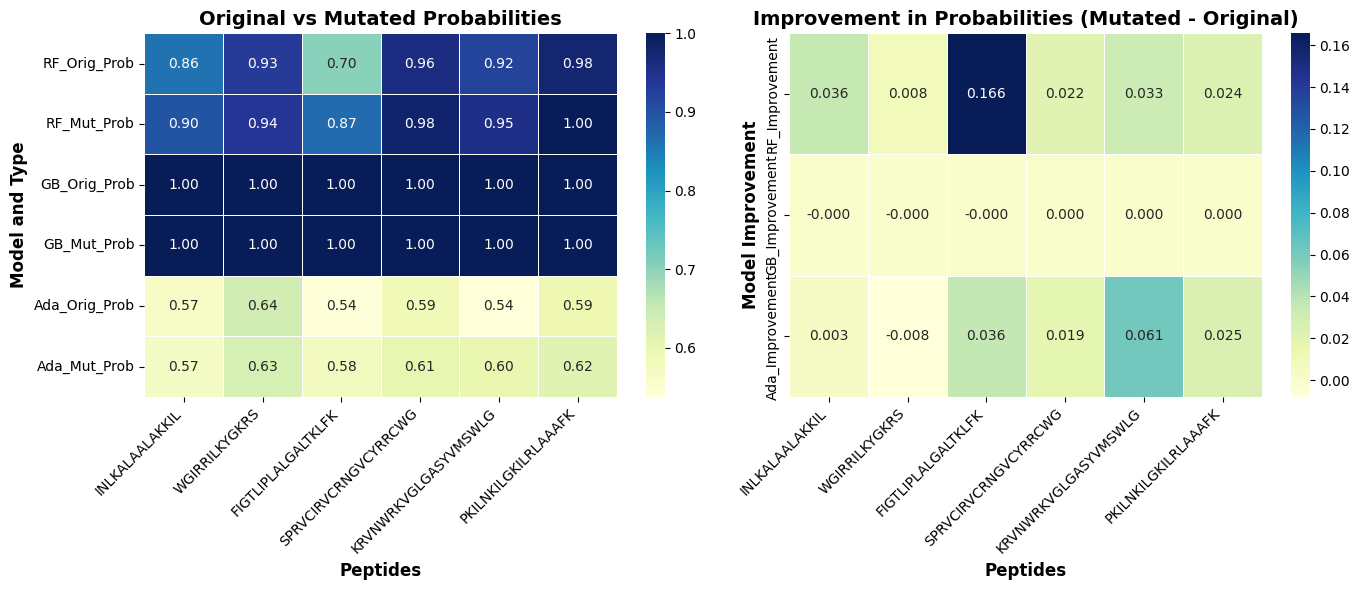

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data from the provided results (first few rows)
data = [
    {
        'Original_Sequence': 'INLKALAALAKKIL',
        'RF_Orig_Prob': 0.862458333,
        'RF_Mut_Prob': 0.898333333,
        'GB_Orig_Prob': 0.999999996,
        'GB_Mut_Prob': 0.999999893,
        'Ada_Orig_Prob': 0.56593978,
        'Ada_Mut_Prob': 0.569225317
    },
    {
        'Original_Sequence': 'WGIRRILKYGKRS',
        'RF_Orig_Prob': 0.932,
        'RF_Mut_Prob': 0.940416667,
        'GB_Orig_Prob': 0.999999999,
        'GB_Mut_Prob': 0.999999997,
        'Ada_Orig_Prob': 0.637963529,
        'Ada_Mut_Prob': 0.629983488
    },
    {
        'Original_Sequence': 'FIGTLIPLALGALTKLFK',
        'RF_Orig_Prob': 0.702892857,
        'RF_Mut_Prob': 0.868583333,
        'GB_Orig_Prob': 0.999999945,
        'GB_Mut_Prob': 0.999999713,
        'Ada_Orig_Prob': 0.541352407,
        'Ada_Mut_Prob': 0.577552408
    },
    {
        'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG',
        'RF_Orig_Prob': 0.958880952,
        'RF_Mut_Prob': 0.980416667,
        'GB_Orig_Prob': 0.999999995,
        'GB_Mut_Prob': 0.999999999,
        'Ada_Orig_Prob': 0.586484939,
        'Ada_Mut_Prob': 0.605461183
    },
    {
        'Original_Sequence': 'KRVNWRKVGLGASYVMSWLG',
        'RF_Orig_Prob': 0.921095238,
        'RF_Mut_Prob': 0.95375,
        'GB_Orig_Prob': 0.999999976,
        'GB_Mut_Prob': 0.999999997,
        'Ada_Orig_Prob': 0.537912605,
        'Ada_Mut_Prob': 0.599350943
    },
    {
        'Original_Sequence': 'PKILNKILGKILRLAAAFK',
        'RF_Orig_Prob': 0.976,
        'RF_Mut_Prob': 1,
        'GB_Orig_Prob': 0.999999998,
        'GB_Mut_Prob': 1,
        'Ada_Orig_Prob': 0.592411442,
        'Ada_Mut_Prob': 0.617319574
    }
]

# Convert data to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Plotting the heatmap for original and mutated probabilities
heatmap_data = df[['RF_Orig_Prob', 'RF_Mut_Prob', 'GB_Orig_Prob', 'GB_Mut_Prob', 'Ada_Orig_Prob', 'Ada_Mut_Prob']]

# Calculate the improvement explicitly for each model pair
# This calculates Mutated Prob - Original Prob for each model pair and assigns column names
improvement_data = pd.DataFrame({
    'RF_Improvement': df['RF_Mut_Prob'] - df['RF_Orig_Prob'],
    'GB_Improvement': df['GB_Mut_Prob'] - df['GB_Orig_Prob'],
    'Ada_Improvement': df['Ada_Mut_Prob'] - df['Ada_Orig_Prob']
})

# Set up the plot for comparing probabilities (Original vs Mutated)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap for original and mutated probabilities
# Transpose heatmap_data for plotting models on the Y-axis and peptides on X-axis
sns.heatmap(heatmap_data.T, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f", ax=ax[0], linewidths=0.5)
ax[0].set_title('Original vs Mutated Probabilities', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Model and Type', fontsize=12, fontweight='bold') # More descriptive label
ax[0].set_xlabel('Peptides', fontsize=12, fontweight='bold')
# Set x-axis tick labels to peptide sequences
ax[0].set_xticklabels(df['Original_Sequence'], rotation=45, ha='right', fontsize=10)


# Heatmap for improvements (Mutated - Original)
# Transpose improvement_data for plotting models on the Y-axis and peptides on X-axis
sns.heatmap(improvement_data.T, annot=True, cmap='YlGnBu', cbar=True, fmt=".3f", ax=ax[1], linewidths=0.5) # Changed fmt to .3f
ax[1].set_title('Improvement in Probabilities (Mutated - Original)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Peptides', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Model Improvement', fontsize=12, fontweight='bold') # More descriptive label
# Set x-axis tick labels to peptide sequences
ax[1].set_xticklabels(df['Original_Sequence'], rotation=45, ha='right', fontsize=10)


# Adjust the layout
plt.tight_layout()
plt.show()

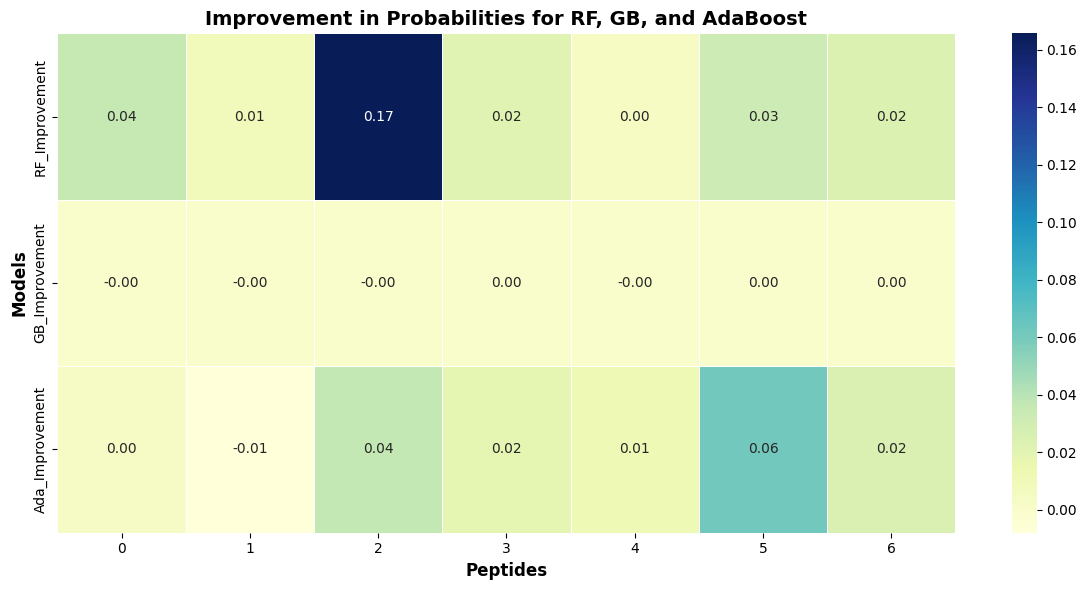

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data: Your peptide sequences, probabilities, and the improvement between original and mutated
data = [
    {'Original_Sequence': 'INLKALAALAKKIL', 'Mutated_Sequence': 'RNKKAKAALAKKIL', 'RF_Orig_Prob': 0.862458333, 'RF_Mut_Prob': 0.898333333, 'GB_Orig_Prob': 0.999999996, 'GB_Mut_Prob': 0.999999893, 'Ada_Orig_Prob': 0.56593978, 'Ada_Mut_Prob': 0.569225317},
    {'Original_Sequence': 'WGIRRILKYGKRS', 'Mutated_Sequence': 'WGIRRILKYRKRS', 'RF_Orig_Prob': 0.932, 'RF_Mut_Prob': 0.940416667, 'GB_Orig_Prob': 0.999999999, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.637963529, 'Ada_Mut_Prob': 0.629983488},
    {'Original_Sequence': 'FIGTLIPLALGALTKLFK', 'Mutated_Sequence': 'FKGTLIAKALGAKKKLRK', 'RF_Orig_Prob': 0.702892857, 'RF_Mut_Prob': 0.868583333, 'GB_Orig_Prob': 0.999999945, 'GB_Mut_Prob': 0.999999713, 'Ada_Orig_Prob': 0.541352407, 'Ada_Mut_Prob': 0.577552408},
    {'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG', 'Mutated_Sequence': 'RARVCIRVCRRRVCYRRCWG', 'RF_Orig_Prob': 0.958880952, 'RF_Mut_Prob': 0.980416667, 'GB_Orig_Prob': 0.999999995, 'GB_Mut_Prob': 0.999999999, 'Ada_Orig_Prob': 0.586484939, 'Ada_Mut_Prob': 0.605461183},
    {'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG', 'Mutated_Sequence': 'SARVCIRVCRRRVCYRRCWG', 'RF_Orig_Prob': 0.958880952, 'RF_Mut_Prob': 0.963416667, 'GB_Orig_Prob': 0.999999995, 'GB_Mut_Prob': 0.999999986, 'Ada_Orig_Prob': 0.586484939, 'Ada_Mut_Prob': 0.597640144},
    {'Original_Sequence': 'KRVNWRKVGLGASYVMSWLG', 'Mutated_Sequence': 'KRVNWRKVGLGARYVMRWLR', 'RF_Orig_Prob': 0.921095238, 'RF_Mut_Prob': 0.95375, 'GB_Orig_Prob': 0.999999976, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.537912605, 'Ada_Mut_Prob': 0.599350943},
    {'Original_Sequence': 'PKILNKILGKILRLAAAFK', 'Mutated_Sequence': 'AKIRRKKLGKILRRAAAFK', 'RF_Orig_Prob': 0.976, 'RF_Mut_Prob': 1, 'GB_Orig_Prob': 0.999999998, 'GB_Mut_Prob': 1, 'Ada_Orig_Prob': 0.592411442, 'Ada_Mut_Prob': 0.617319574}
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Create a column for improvement: Mut_Prob - Orig_Prob
df['RF_Improvement'] = df['RF_Mut_Prob'] - df['RF_Orig_Prob']
df['GB_Improvement'] = df['GB_Mut_Prob'] - df['GB_Orig_Prob']
df['Ada_Improvement'] = df['Ada_Mut_Prob'] - df['Ada_Orig_Prob']

# Plotting the heatmap for the improvement (Mutated vs. Original probabilities)
fig, ax = plt.subplots(figsize=(12, 6))

# The improvement data is now in the columns 'RF_Improvement', 'GB_Improvement', 'Ada_Improvement'
improvement_data = df[['RF_Improvement', 'GB_Improvement', 'Ada_Improvement']]

# Use a heatmap to visualize the improvements in the models
sns.heatmap(improvement_data.T, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f", ax=ax, linewidths=0.5)

# Title and labels
ax.set_title('Improvement in Probabilities for RF, GB, and AdaBoost', fontsize=14, fontweight='bold')
ax.set_xlabel('Peptides', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()



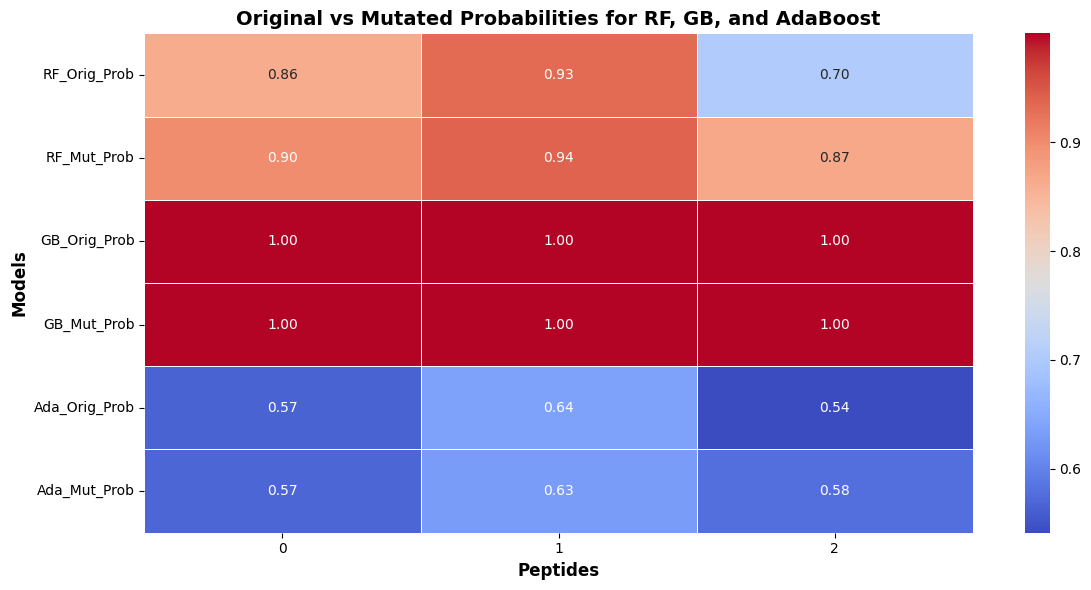

Original: INLKALAALAKKIL
Mutated: RNKKAKAALAKKIL
Highlighted: [I->R]N[L->K]KA[L->K]AALAKKIL
-----------
Original: WGIRRILKYGKRS
Mutated: WGIRRILKYRKRS
Highlighted: WGIRRILKY[G->R]KRS
-----------
Original: FIGTLIPLALGALTKLFK
Mutated: FKGTLIAKALGAKKKLRK
Highlighted: F[I->K]GTLI[P->A][L->K]ALGA[L->K][T->K]KL[F->R]K
-----------


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data (replace with your actual dataset)
data = [
    {'Original_Sequence': 'INLKALAALAKKIL', 'Mutated_Sequence': 'RNKKAKAALAKKIL', 'RF_Orig_Prob': 0.862458333, 'RF_Mut_Prob': 0.898333333, 'GB_Orig_Prob': 0.999999996, 'GB_Mut_Prob': 0.999999893, 'Ada_Orig_Prob': 0.56593978, 'Ada_Mut_Prob': 0.569225317},
    {'Original_Sequence': 'WGIRRILKYGKRS', 'Mutated_Sequence': 'WGIRRILKYRKRS', 'RF_Orig_Prob': 0.932, 'RF_Mut_Prob': 0.940416667, 'GB_Orig_Prob': 0.999999999, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.637963529, 'Ada_Mut_Prob': 0.629983488},
    {'Original_Sequence': 'FIGTLIPLALGALTKLFK', 'Mutated_Sequence': 'FKGTLIAKALGAKKKLRK', 'RF_Orig_Prob': 0.702892857, 'RF_Mut_Prob': 0.868583333, 'GB_Orig_Prob': 0.999999945, 'GB_Mut_Prob': 0.999999713, 'Ada_Orig_Prob': 0.541352407, 'Ada_Mut_Prob': 0.577552408},
    # Add more rows as needed
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Function to highlight substituted amino acids between original and mutated sequences
def highlight_mutations(orig_seq, mutated_seq):
    highlighted = []
    for o, m in zip(orig_seq, mutated_seq):
        if o != m:
            highlighted.append(f'[{o}->{m}]')  # Show the substitution
        else:
            highlighted.append(o)
    return ''.join(highlighted)

# Create a new column for the highlighted mutations
df['Highlighted_Mutations'] = [highlight_mutations(row['Original_Sequence'], row['Mutated_Sequence']) for _, row in df.iterrows()]

# Plotting the comparison of probabilities (Original vs. Mutated)
fig, ax = plt.subplots(figsize=(12, 6))

# Probability comparison data
prob_comparison = df[['RF_Orig_Prob', 'RF_Mut_Prob', 'GB_Orig_Prob', 'GB_Mut_Prob', 'Ada_Orig_Prob', 'Ada_Mut_Prob']]

# Create the heatmap for the comparison of original and mutated probabilities
sns.heatmap(prob_comparison.T, annot=True, cmap='coolwarm', fmt=".2f", ax=ax, linewidths=0.5)

# Set titles and labels
ax.set_title('Original vs Mutated Probabilities for RF, GB, and AdaBoost', fontsize=14, fontweight='bold')
ax.set_xlabel('Peptides', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

# Display the highlighted mutations (first few sequences for illustration)
for idx, row in df.iterrows():
    print(f"Original: {row['Original_Sequence']}")
    print(f"Mutated: {row['Mutated_Sequence']}")
    print(f"Highlighted: {row['Highlighted_Mutations']}")
    print("-----------")


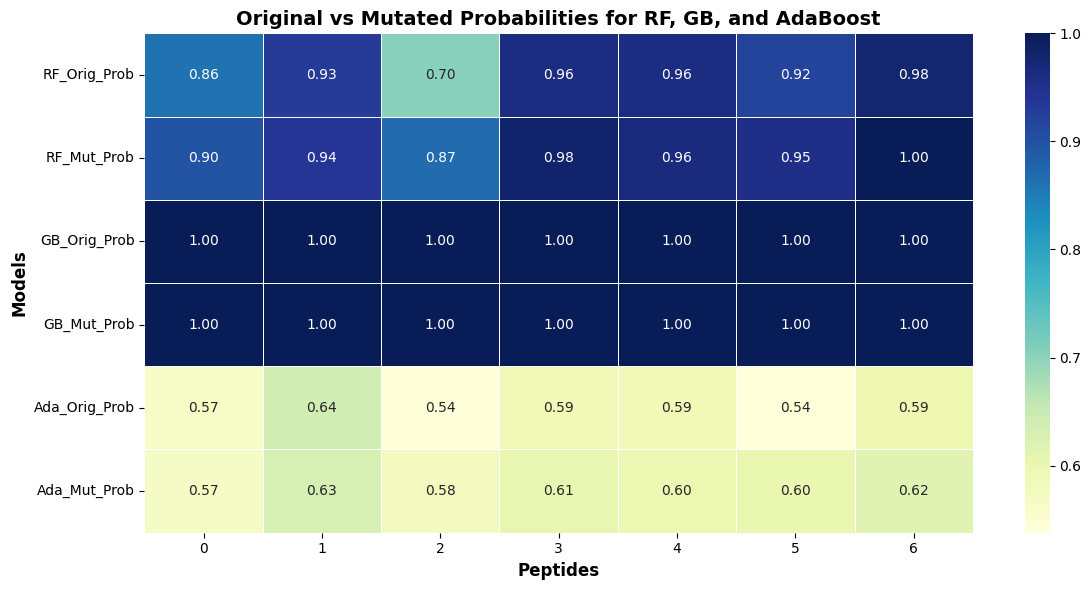

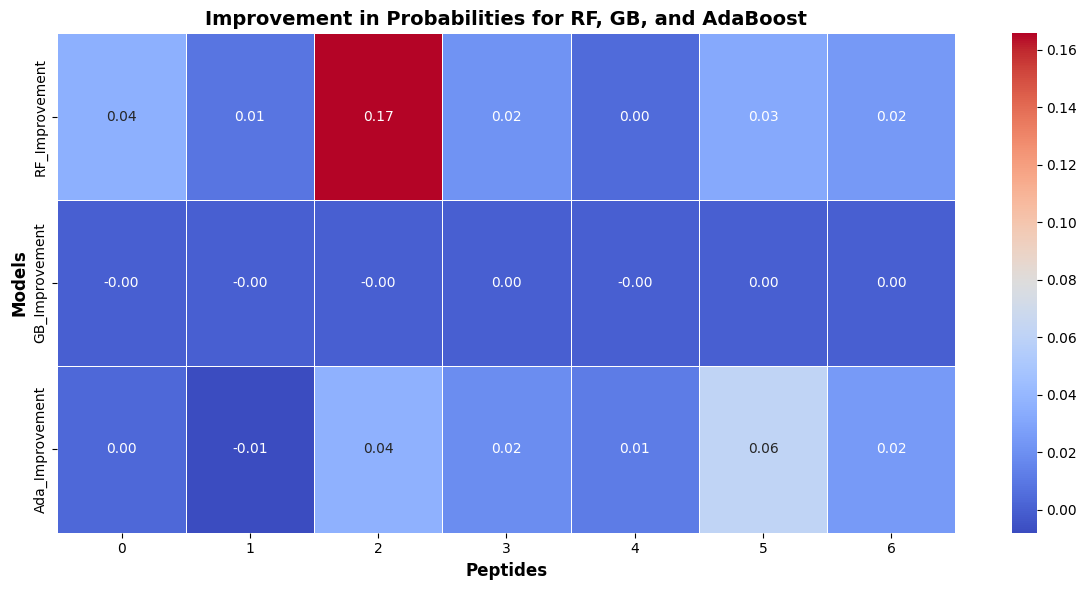

Original: INLKALAALAKKIL
Mutated: RNKKAKAALAKKIL
RF - Original Probability: 0.86, Mutated Probability: 0.90, Improvement: 0.04
GB - Original Probability: 1.00, Mutated Probability: 1.00, Improvement: -0.00
Ada - Original Probability: 0.57, Mutated Probability: 0.57, Improvement: 0.00
-----------
Original: WGIRRILKYGKRS
Mutated: WGIRRILKYRKRS
RF - Original Probability: 0.93, Mutated Probability: 0.94, Improvement: 0.01
GB - Original Probability: 1.00, Mutated Probability: 1.00, Improvement: -0.00
Ada - Original Probability: 0.64, Mutated Probability: 0.63, Improvement: -0.01
-----------
Original: FIGTLIPLALGALTKLFK
Mutated: FKGTLIAKALGAKKKLRK
RF - Original Probability: 0.70, Mutated Probability: 0.87, Improvement: 0.17
GB - Original Probability: 1.00, Mutated Probability: 1.00, Improvement: -0.00
Ada - Original Probability: 0.54, Mutated Probability: 0.58, Improvement: 0.04
-----------
Original: SPRVCIRVCRNGVCYRRCWG
Mutated: RARVCIRVCRRRVCYRRCWG
RF - Original Probability: 0.96, Mutated 

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq

# Sample data (replace with your actual dataset)
data = [
    {'Original_Sequence': 'INLKALAALAKKIL', 'Mutated_Sequence': 'RNKKAKAALAKKIL', 'RF_Orig_Prob': 0.862458333, 'RF_Mut_Prob': 0.898333333, 'GB_Orig_Prob': 0.999999996, 'GB_Mut_Prob': 0.999999893, 'Ada_Orig_Prob': 0.56593978, 'Ada_Mut_Prob': 0.569225317},
    {'Original_Sequence': 'WGIRRILKYGKRS', 'Mutated_Sequence': 'WGIRRILKYRKRS', 'RF_Orig_Prob': 0.932, 'RF_Mut_Prob': 0.940416667, 'GB_Orig_Prob': 0.999999999, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.637963529, 'Ada_Mut_Prob': 0.629983488},
    {'Original_Sequence': 'FIGTLIPLALGALTKLFK', 'Mutated_Sequence': 'FKGTLIAKALGAKKKLRK', 'RF_Orig_Prob': 0.702892857, 'RF_Mut_Prob': 0.868583333, 'GB_Orig_Prob': 0.999999945, 'GB_Mut_Prob': 0.999999713, 'Ada_Orig_Prob': 0.541352407, 'Ada_Mut_Prob': 0.577552408},
    {'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG', 'Mutated_Sequence': 'RARVCIRVCRRRVCYRRCWG', 'RF_Orig_Prob': 0.958880952, 'RF_Mut_Prob': 0.980416667, 'GB_Orig_Prob': 0.999999995, 'GB_Mut_Prob': 0.999999999, 'Ada_Orig_Prob': 0.586484939, 'Ada_Mut_Prob': 0.605461183},
    {'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG', 'Mutated_Sequence': 'SARVCIRVCRRRVCYRRCWG', 'RF_Orig_Prob': 0.958880952, 'RF_Mut_Prob': 0.963416667, 'GB_Orig_Prob': 0.999999995, 'GB_Mut_Prob': 0.999999986, 'Ada_Orig_Prob': 0.586484939, 'Ada_Mut_Prob': 0.597640144},
    {'Original_Sequence': 'KRVNWRKVGLGASYVMSWLG', 'Mutated_Sequence': 'KRVNWRKVGLGARYVMRWLR', 'RF_Orig_Prob': 0.921095238, 'RF_Mut_Prob': 0.95375, 'GB_Orig_Prob': 0.999999976, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.537912605, 'Ada_Mut_Prob': 0.599350943},
    {'Original_Sequence': 'PKILNKILGKILRLAAAFK', 'Mutated_Sequence': 'AKIRRKKLGKILRRAAAFK', 'RF_Orig_Prob': 0.976, 'RF_Mut_Prob': 1, 'GB_Orig_Prob': 0.999999998, 'GB_Mut_Prob': 1, 'Ada_Orig_Prob': 0.592411442, 'Ada_Mut_Prob': 0.617319574}
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Calculate the difference in probabilities (improvement) between original and mutated sequences
df['RF_Improvement'] = df['RF_Mut_Prob'] - df['RF_Orig_Prob']
df['GB_Improvement'] = df['GB_Mut_Prob'] - df['GB_Orig_Prob']
df['Ada_Improvement'] = df['Ada_Mut_Prob'] - df['Ada_Orig_Prob']

# Create a heatmap for the probability comparison (Original vs Mutated)
fig, ax = plt.subplots(figsize=(12, 6))

# Probability comparison data
prob_comparison = df[['RF_Orig_Prob', 'RF_Mut_Prob', 'GB_Orig_Prob', 'GB_Mut_Prob', 'Ada_Orig_Prob', 'Ada_Mut_Prob']]

# Create the heatmap for the comparison of original and mutated probabilities
sns.heatmap(prob_comparison.T, annot=True, cmap='YlGnBu', fmt=".2f", ax=ax, linewidths=0.5)

# Set titles and labels
ax.set_title('Original vs Mutated Probabilities for RF, GB, and AdaBoost', fontsize=14, fontweight='bold')
ax.set_xlabel('Peptides', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

# Plot the improvements between original and mutated probabilities
fig, ax = plt.subplots(figsize=(12, 6))

# Improvement comparison data
improvement_comparison = df[['RF_Improvement', 'GB_Improvement', 'Ada_Improvement']]

# Create the heatmap for the improvement in probabilities
sns.heatmap(improvement_comparison.T, annot=True, cmap='coolwarm', fmt=".2f", ax=ax, linewidths=0.5)

# Set titles and labels
ax.set_title('Improvement in Probabilities for RF, GB, and AdaBoost', fontsize=14, fontweight='bold')
ax.set_xlabel('Peptides', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

# Display the sequences and probability changes
for idx, row in df.iterrows():
    print(f"Original: {row['Original_Sequence']}")
    print(f"Mutated: {row['Mutated_Sequence']}")
    print(f"RF - Original Probability: {row['RF_Orig_Prob']:.2f}, Mutated Probability: {row['RF_Mut_Prob']:.2f}, Improvement: {row['RF_Improvement']:.2f}")
    print(f"GB - Original Probability: {row['GB_Orig_Prob']:.2f}, Mutated Probability: {row['GB_Mut_Prob']:.2f}, Improvement: {row['GB_Improvement']:.2f}")
    print(f"Ada - Original Probability: {row['Ada_Orig_Prob']:.2f}, Mutated Probability: {row['Ada_Mut_Prob']:.2f}, Improvement: {row['Ada_Improvement']:.2f}")
    print("-----------")


| **Original Sequence** | **Mutated Sequence** | **RF - Original Probability** | **RF - Mutated Probability** | **RF - Improvement** | **GB - Original Probability** | **GB - Mutated Probability** | **GB - Improvement** | **Ada - Original Probability** | **Ada - Mutated Probability** | **Ada - Improvement** |
| --------------------- | -------------------- | ----------------------------- | ---------------------------- | -------------------- | ----------------------------- | ---------------------------- | -------------------- | ------------------------------ | ----------------------------- | --------------------- |
| INLKALAALAKKIL        | RNKKAKAALAKKIL       | 0.86                          | 0.90                         | 0.04                 | 1.00                          | 1.00                         | 0.00                 | 0.57                           | 0.57                          | 0.00                  |
| WGIRRILKYGKRS         | WGIRRILKYRKRS        | 0.93                          | 0.94                         | 0.01                 | 1.00                          | 1.00                         | 0.00                 | 0.64                           | 0.63                          | -0.01                 |
| FIGTLIPLALGALTKLFK    | FKGTLIAKALGAKKKLRK   | 0.70                          | 0.87                         | 0.17                 | 1.00                          | 1.00                         | 0.00                 | 0.54                           | 0.58                          | 0.04                  |
| SPRVCIRVCRNGVCYRRCWG  | RARVCIRVCRRRVCYRRCWG | 0.96                          | 0.98                         | 0.02                 | 1.00                          | 1.00                         | 0.00                 | 0.59                           | 0.61                          | 0.02                  |
| SPRVCIRVCRNGVCYRRCWG  | SARVCIRVCRRRVCYRRCWG | 0.96                          | 0.96                         | 0.00                 | 1.00                          | 1.00                         | 0.00                 | 0.59                           | 0.60                          | 0.01                  |
| KRVNWRKVGLGASYVMSWLG  | KRVNWRKVGLGARYVMRWLR | 0.92                          | 0.95                         | 0.03                 | 1.00                          | 1.00                         | 0.00                 | 0.54                           | 0.60                          | 0.06                  |
| PKILNKILGKILRLAAAFK   | AKIRRKKLGKILRRAAAFK  | 0.98                          | 1.00                         | 0.02                 | 1.00                          | 1.00                         | 0.00                 | 0.59                           | 0.62                          | 0.02                  |


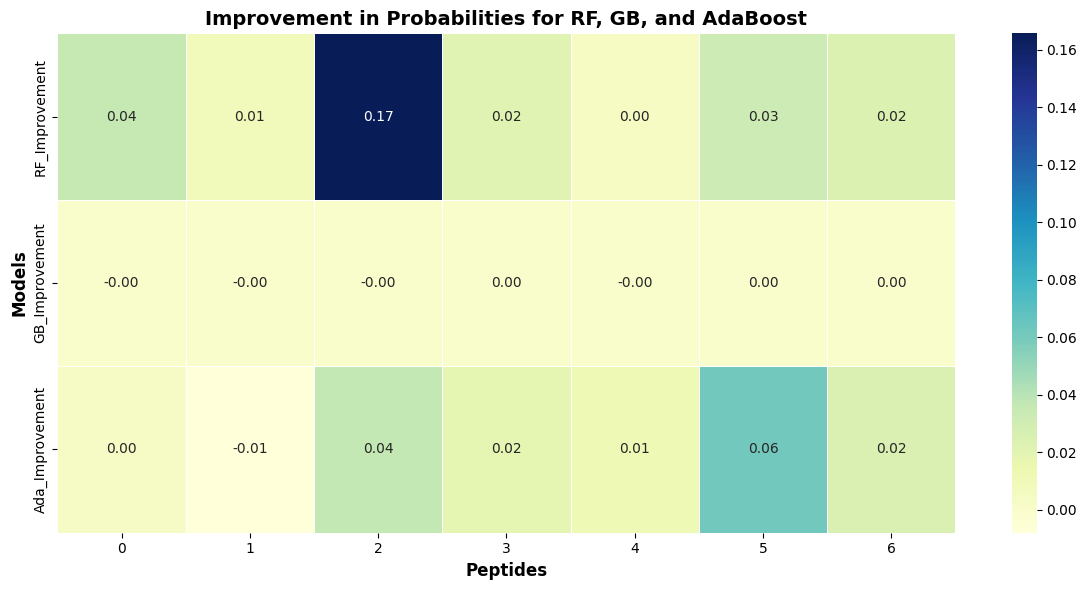

Original: INLKALAALAKKIL
Mutated: RNKKAKAALAKKIL
Highlighted: [I->R]N[L->K]KA[L->K]AALAKKIL
-----------
Original: WGIRRILKYGKRS
Mutated: WGIRRILKYRKRS
Highlighted: WGIRRILKY[G->R]KRS
-----------
Original: FIGTLIPLALGALTKLFK
Mutated: FKGTLIAKALGAKKKLRK
Highlighted: F[I->K]GTLI[P->A][L->K]ALGA[L->K][T->K]KL[F->R]K
-----------
Original: SPRVCIRVCRNGVCYRRCWG
Mutated: RARVCIRVCRRRVCYRRCWG
Highlighted: [S->R][P->A]RVCIRVCR[N->R][G->R]VCYRRCWG
-----------
Original: SPRVCIRVCRNGVCYRRCWG
Mutated: SARVCIRVCRRRVCYRRCWG
Highlighted: S[P->A]RVCIRVCR[N->R][G->R]VCYRRCWG
-----------
Original: KRVNWRKVGLGASYVMSWLG
Mutated: KRVNWRKVGLGARYVMRWLR
Highlighted: KRVNWRKVGLGA[S->R]YVM[S->R]WL[G->R]
-----------
Original: PKILNKILGKILRLAAAFK
Mutated: AKIRRKKLGKILRRAAAFK
Highlighted: [P->A]KI[L->R][N->R]K[I->K]LGKILR[L->R]AAAFK
-----------


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq

# Sample data (replace with your actual dataset)
data = [
    {'Original_Sequence': 'INLKALAALAKKIL', 'Mutated_Sequence': 'RNKKAKAALAKKIL', 'RF_Orig_Prob': 0.862458333, 'RF_Mut_Prob': 0.898333333, 'GB_Orig_Prob': 0.999999996, 'GB_Mut_Prob': 0.999999893, 'Ada_Orig_Prob': 0.56593978, 'Ada_Mut_Prob': 0.569225317},
    {'Original_Sequence': 'WGIRRILKYGKRS', 'Mutated_Sequence': 'WGIRRILKYRKRS', 'RF_Orig_Prob': 0.932, 'RF_Mut_Prob': 0.940416667, 'GB_Orig_Prob': 0.999999999, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.637963529, 'Ada_Mut_Prob': 0.629983488},
    {'Original_Sequence': 'FIGTLIPLALGALTKLFK', 'Mutated_Sequence': 'FKGTLIAKALGAKKKLRK', 'RF_Orig_Prob': 0.702892857, 'RF_Mut_Prob': 0.868583333, 'GB_Orig_Prob': 0.999999945, 'GB_Mut_Prob': 0.999999713, 'Ada_Orig_Prob': 0.541352407, 'Ada_Mut_Prob': 0.577552408},
    {'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG', 'Mutated_Sequence': 'RARVCIRVCRRRVCYRRCWG', 'RF_Orig_Prob': 0.958880952, 'RF_Mut_Prob': 0.980416667, 'GB_Orig_Prob': 0.999999995, 'GB_Mut_Prob': 0.999999999, 'Ada_Orig_Prob': 0.586484939, 'Ada_Mut_Prob': 0.605461183},
    {'Original_Sequence': 'SPRVCIRVCRNGVCYRRCWG', 'Mutated_Sequence': 'SARVCIRVCRRRVCYRRCWG', 'RF_Orig_Prob': 0.958880952, 'RF_Mut_Prob': 0.963416667, 'GB_Orig_Prob': 0.999999995, 'GB_Mut_Prob': 0.999999986, 'Ada_Orig_Prob': 0.586484939, 'Ada_Mut_Prob': 0.597640144},
    {'Original_Sequence': 'KRVNWRKVGLGASYVMSWLG', 'Mutated_Sequence': 'KRVNWRKVGLGARYVMRWLR', 'RF_Orig_Prob': 0.921095238, 'RF_Mut_Prob': 0.95375, 'GB_Orig_Prob': 0.999999976, 'GB_Mut_Prob': 0.999999997, 'Ada_Orig_Prob': 0.537912605, 'Ada_Mut_Prob': 0.599350943},
    {'Original_Sequence': 'PKILNKILGKILRLAAAFK', 'Mutated_Sequence': 'AKIRRKKLGKILRRAAAFK', 'RF_Orig_Prob': 0.976, 'RF_Mut_Prob': 1, 'GB_Orig_Prob': 0.999999998, 'GB_Mut_Prob': 1, 'Ada_Orig_Prob': 0.592411442, 'Ada_Mut_Prob': 0.617319574}
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Create a column for improvement: Mut_Prob - Orig_Prob
df['RF_Improvement'] = df['RF_Mut_Prob'] - df['RF_Orig_Prob']
df['GB_Improvement'] = df['GB_Mut_Prob'] - df['GB_Orig_Prob']
df['Ada_Improvement'] = df['Ada_Mut_Prob'] - df['Ada_Orig_Prob']

# Function to highlight substituted amino acids between original and mutated sequences
def highlight_mutations(orig_seq, mutated_seq):
    highlighted = []
    for o, m in zip(orig_seq, mutated_seq):
        if o != m:
            highlighted.append(f'[{o}->{m}]')  # Show the substitution
        else:
            highlighted.append(o)
    return ''.join(highlighted)

# Create a new column for the highlighted mutations
df['Highlighted_Mutations'] = [highlight_mutations(row['Original_Sequence'], row['Mutated_Sequence']) for _, row in df.iterrows()]

# Plotting the comparison of probabilities (Original vs. Mutated)
fig, ax = plt.subplots(figsize=(12, 6))

# Probability comparison data
prob_comparison = df[['RF_Improvement', 'GB_Improvement', 'Ada_Improvement']]

# Create the heatmap for the comparison of original and mutated probabilities
sns.heatmap(prob_comparison.T, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f", ax=ax, linewidths=0.5)

# Set titles and labels
ax.set_title('Improvement in Probabilities for RF, GB, and AdaBoost', fontsize=14, fontweight='bold')
ax.set_xlabel('Peptides', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

# Display the highlighted mutations (first few sequences for illustration)
for idx, row in df.iterrows():
    print(f"Original: {row['Original_Sequence']}")
    print(f"Mutated: {row['Mutated_Sequence']}")
    print(f"Highlighted: {row['Highlighted_Mutations']}")
    print("-----------")


Conclusion:
Yes, you can adapt this code to enhance active peptides as well. Instead of making inactive peptides active, you would:

Focus on enhancing their activity (e.g., improving hydrophobicity, charge balance, etc.).

Use the existing mutation and evaluation framework to experiment with modifications that improve activity.

Modify the AMP criteria slightly to be more flexible for optimizing active peptides.

This approach would allow you to apply data-driven optimization of active peptides to find even more potent candidates.